# Phase 2: Data Visualization and EDA

In [2]:
#Importing all the relevant packages

import numpy as np
import pandas as pd

import os
import pickle
from sys import platform


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec

import seaborn as sns
color = sns.color_palette()
sns.set(font_scale=1.5)


import datetime

pd.options.display.max_colwidth = -1

In [3]:
#Loading from pickle file 
df, float_cols, cat_cols, perc_cols, date_cols = \
                            pickle.load(open("C:\Anaconda\semester1\p2p\p2p_eda_1_data.pickle", "rb" ))

In [4]:
# Remove all loans that are too recent to have been paid off or charged-off or defaulted
n_rows = len(df)
df = df[df.loan_status.isin(['Fully Paid','Charged Off','Default'])]
print("Removed " + str(n_rows - len(df)) + " rows")

Removed 567874 rows


In [5]:
def explore_columns():

    for i in float_cols + perc_cols:
        sns.boxplot(df[i])
        
        # Print the three highest values
        highest_vals = sorted(df[i], reverse=True)[:3]
        smallest_val = df[i].min()
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(df[i]))) + " distinct values")
        print(df[i].value_counts())
        print("")
        print("")
    
    # Date columns
    for i in date_cols:
        df[df[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts().sort_index().plot()
        plt.title(i + " (" + str(df[i].isnull().sum()) + " null values)")
        plt.show()

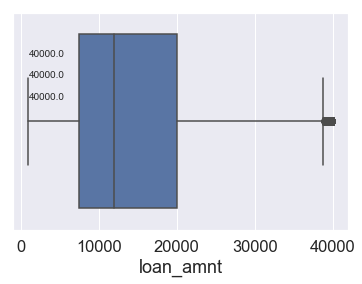

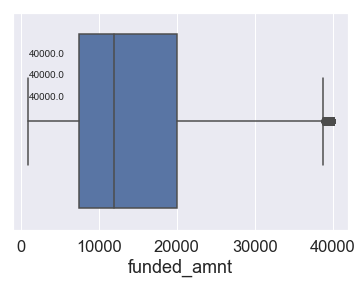

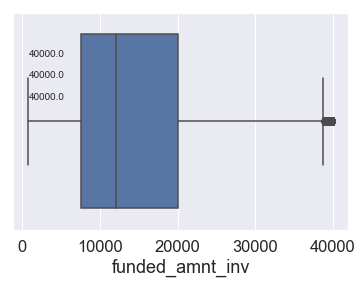

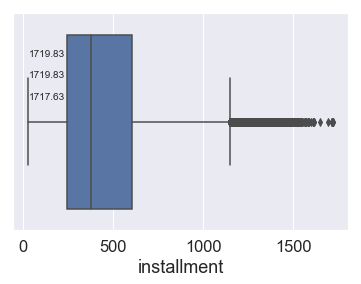

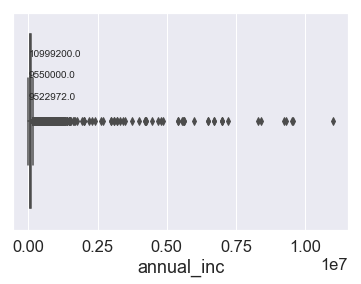

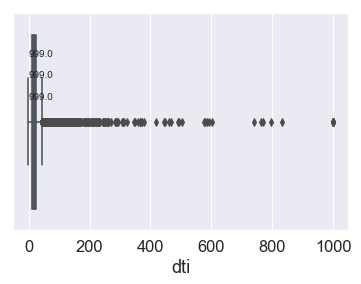

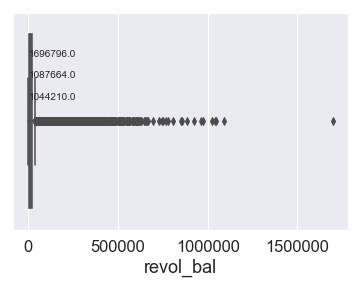

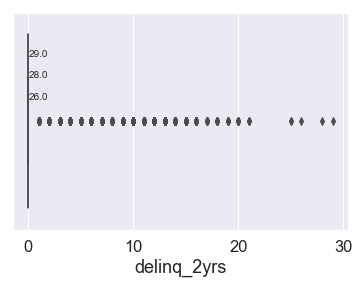

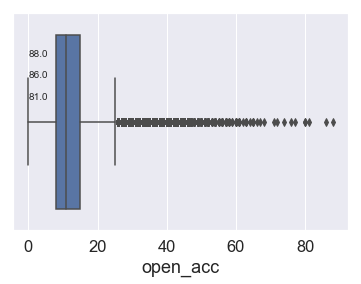

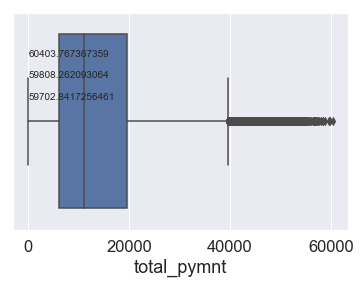

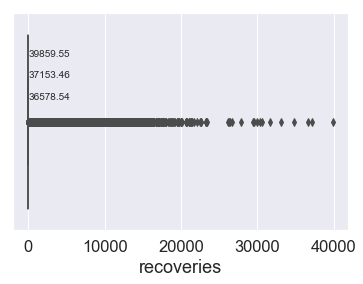

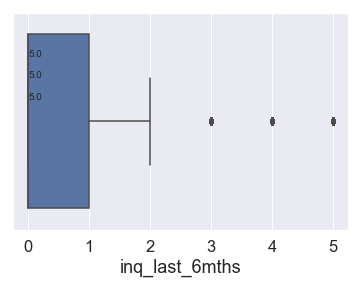

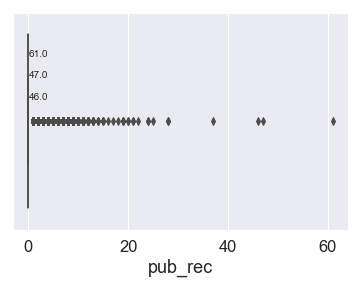

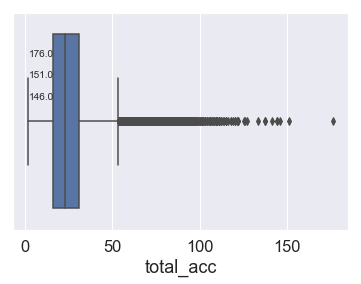

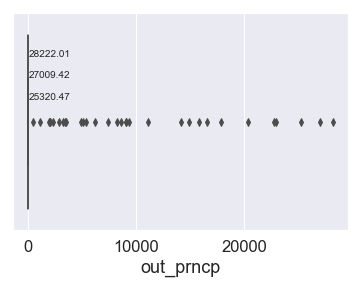

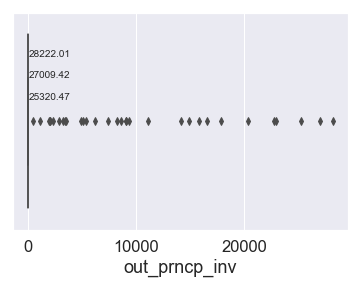

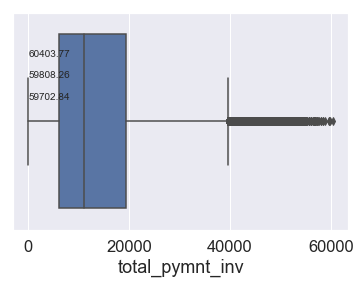

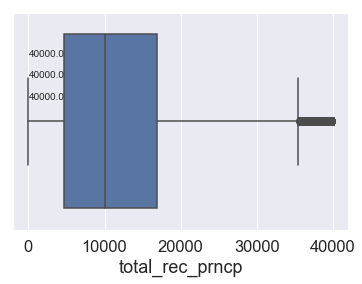

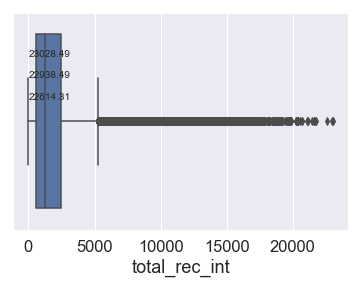

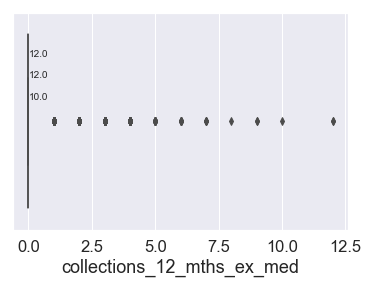

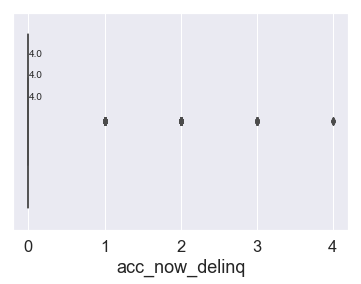

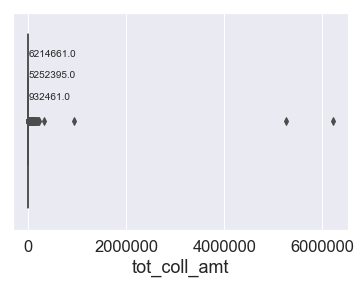

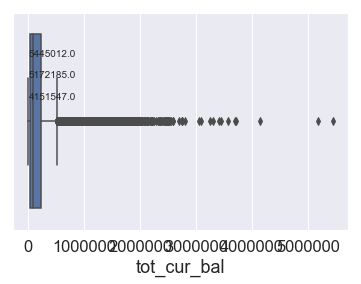

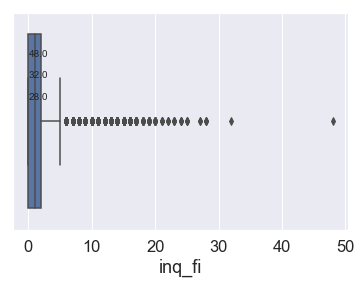

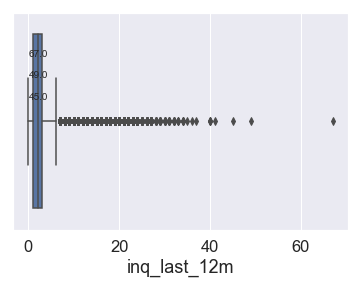

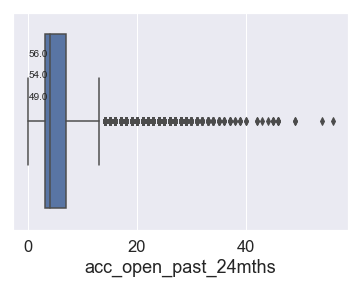

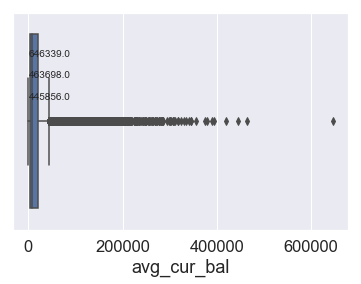

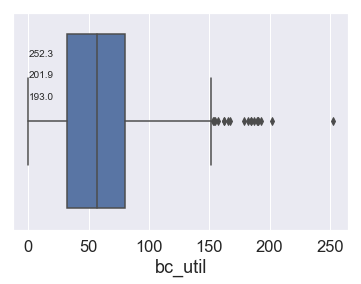

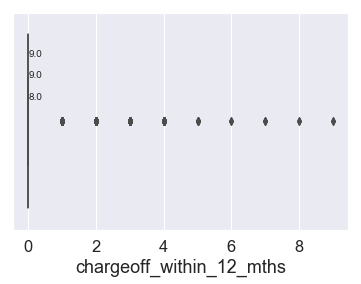

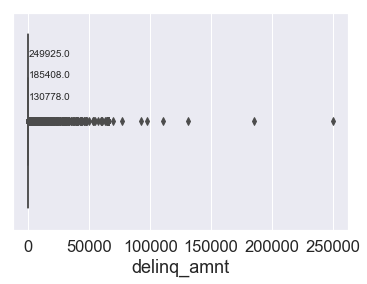

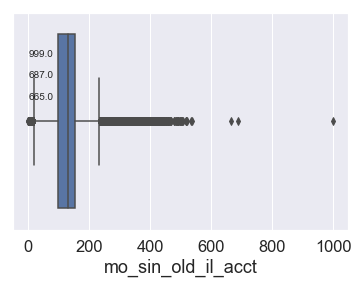

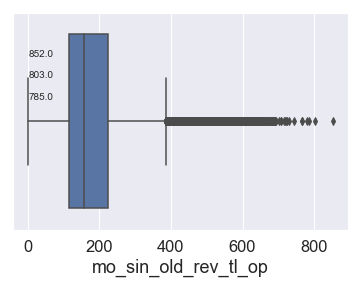

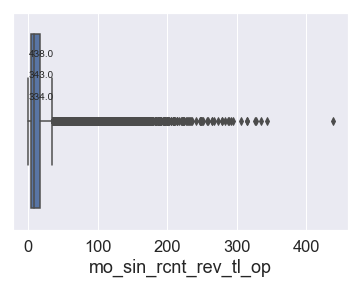

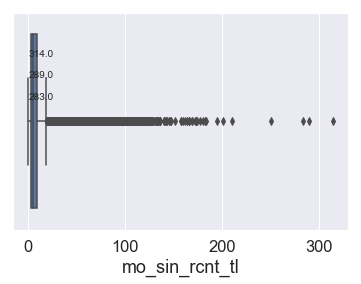

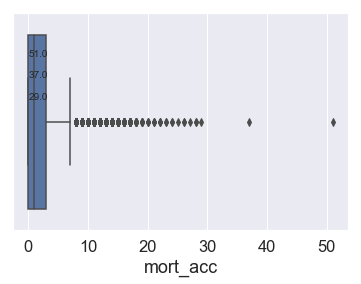

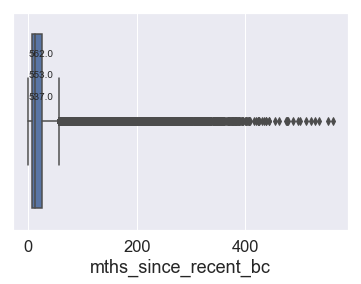

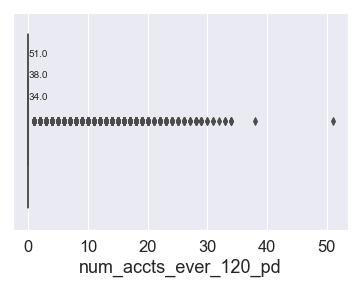

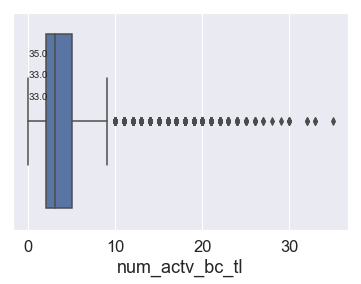

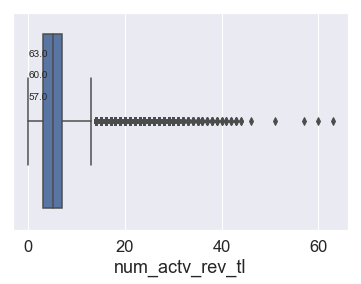

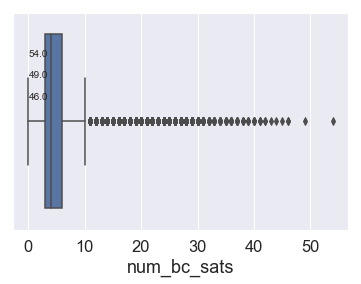

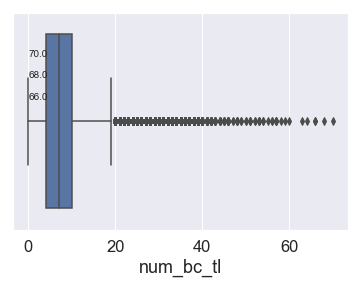

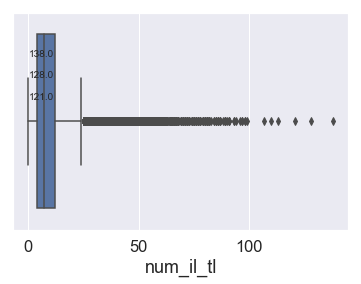

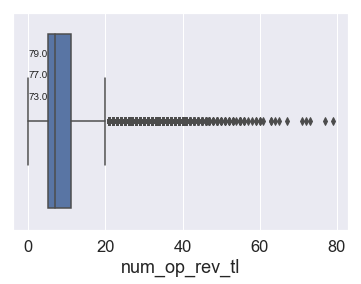

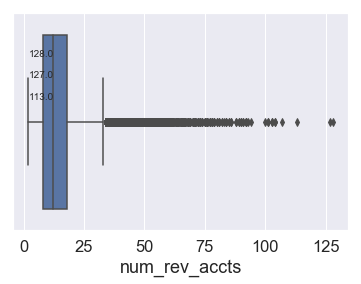

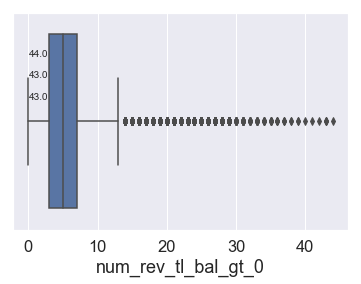

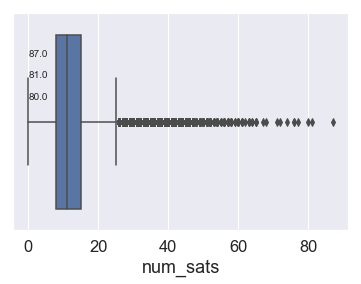

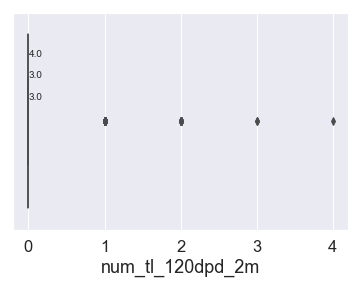

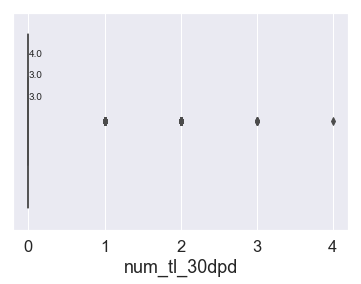

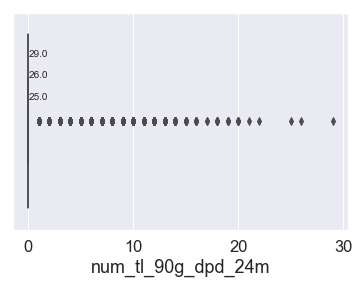

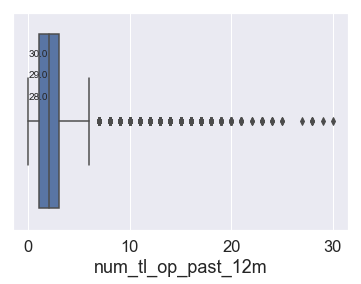

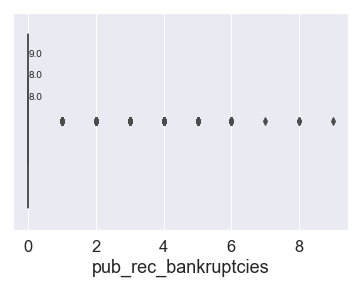

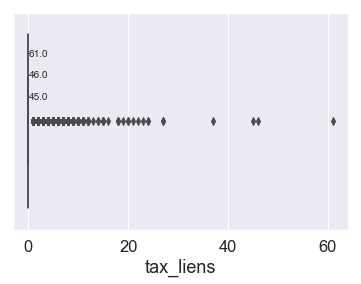

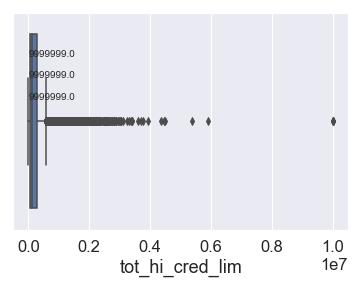

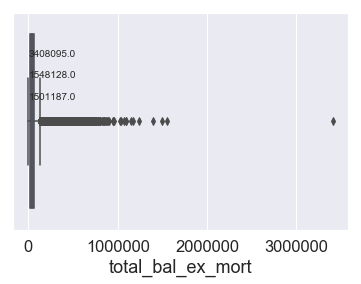

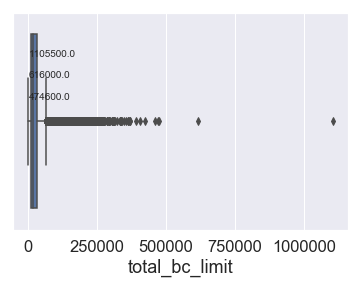

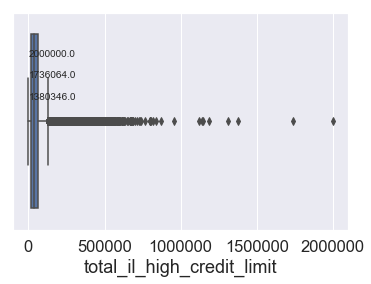

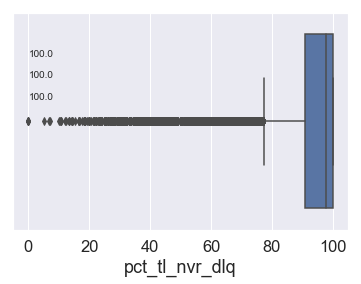

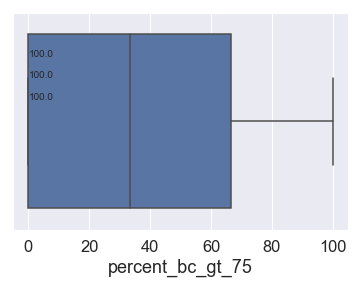

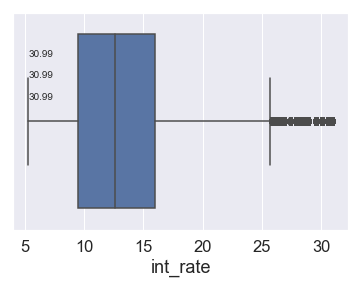

term
2 distinct values
 36 months    361787
 60 months    106977
Name: term, dtype: int64


grade
7 distinct values
C    142209
B    137232
A    79455 
D    66866 
E    28617 
F    10420 
G    3965  
Name: grade, dtype: int64


sub_grade
35 distinct values
B5    32856
C1    32668
C2    28052
B4    28021
C4    27757
C5    27145
C3    26587
B3    26059
B1    25772
B2    24524
A1    18846
A5    18554
D1    16533
A4    16009
D2    15857
D3    13583
A2    13149
A3    12897
D4    11363
D5    9530 
E1    6926 
E2    5917 
E3    5486 
E5    5348 
E4    4940 
F1    3226 
F2    2191 
F3    1895 
F4    1629 
F5    1479 
G1    1191 
G2    807  
G3    693  
G4    670  
G5    604  
Name: sub_grade, dtype: int64


emp_length
11 distinct values
10+ years    168523
2 years      46621 
3 years      40911 
< 1 year     40772 
1 year       34046 
5 years      30918 
4 years      30400 
6 years      21659 
8 years      19211 
9 years      18510 
7 years      17193 
Name: emp_length, dtype: int64


home_own

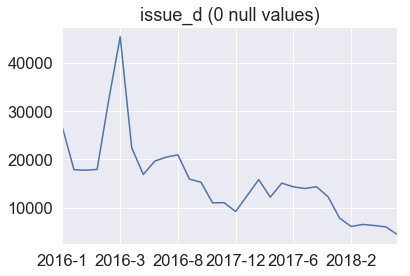

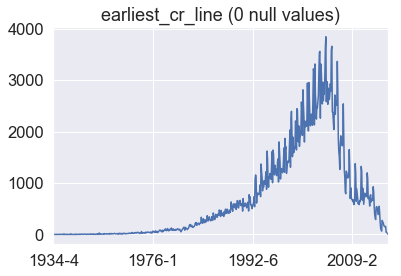

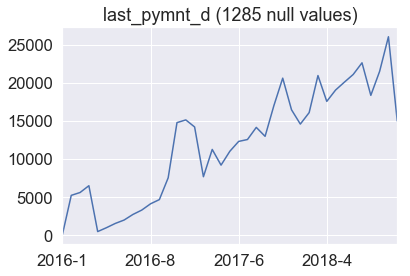

In [6]:
explore_columns()

In [7]:
#Assign charge-offs to positive class 1 and fully paid loans to negative class 0 
df['loan_outcome'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off':1, 'Default':1})

## Outlier Handling 

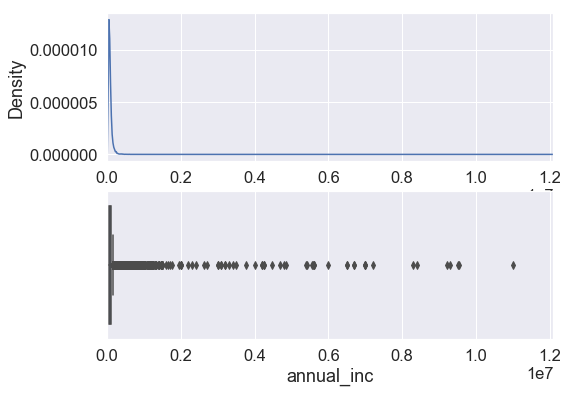

In [8]:
#Let's look at annual income variable
i = 'annual_inc'
 
plt.figure(figsize=(8,6))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1) 
ax = df[i].plot(kind='kde')
plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x=df[i]);

In [9]:
# Remove any zeros (otherwise we get (-inf)
#df.loc[df.annual_inc == 0.0, 'annual_inc'] = np.nan
# Drop NA
#df.dropna(inplace=True)
# Log Transform
df[i+'_log'] = np.log(1+df[i])

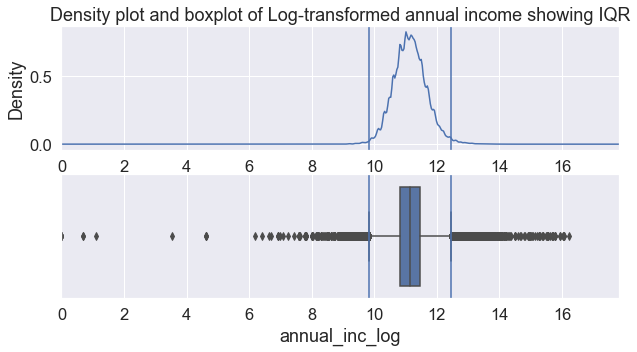

In [10]:
#Plot after log-transform and displaying IQR 
q3, q1 = np.percentile(df.annual_inc_log, [75,25])
iqr = q3 - q1
min = q1 - (iqr*1.5)
max = q3 + (iqr*1.5)

i = 'annual_inc_log'
 
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
plt.title('Density plot and boxplot of Log-transformed annual income showing IQR')
ax.set_xticklabels('')

ax = df[i].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x=df[i])
plt.axvline(x=min)
plt.axvline(x=max)


In [11]:
df['is_outlier'] = 0
 
df.loc[df[i] < min, 'is_outlier'] = 1
df.loc[df[i] > max, 'is_outlier'] = 1

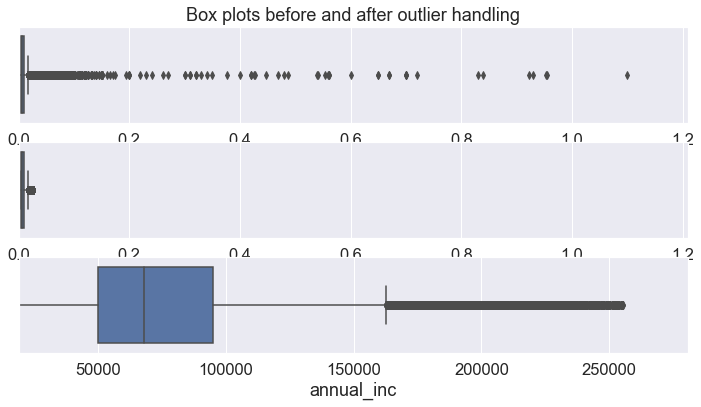

In [12]:
df_wd_outlier = df.loc[df['is_outlier'] == 0, :]
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.xlim(df['annual_inc'].min(), df['annual_inc'].max()*1.1)
sns.boxplot(x=df['annual_inc'])
plt.title('Box plots before and after outlier handling')
ax.set_xticklabels('')


plt.subplot(312)
plt.xlim(df['annual_inc'].min(), df['annual_inc'].max()*1.1)
sns.boxplot(x=df_wd_outlier['annual_inc'])


plt.subplot(313)
plt.xlim(df_wd_outlier['annual_inc'].min(), df_wd_outlier['annual_inc'].max()*1.1)
sns.boxplot(x=df_wd_outlier['annual_inc']);



# Correlation

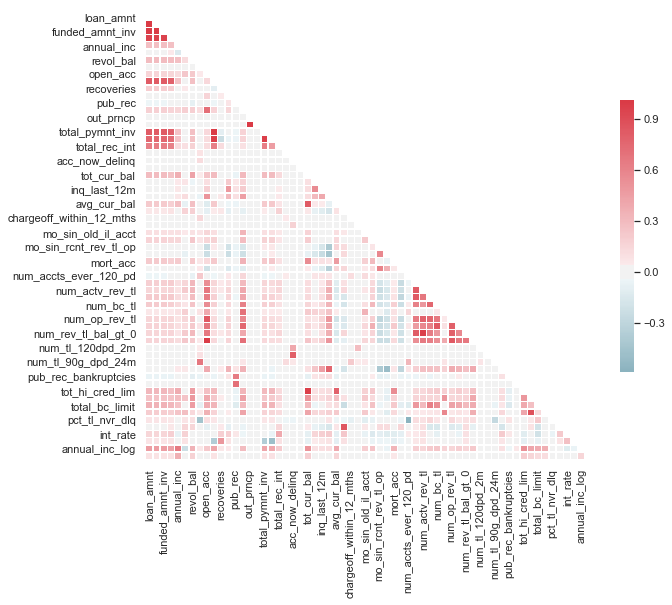

In [13]:
sns.set(style="white")

# correlation matrix
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.01, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [14]:
for i in corr.index:
    for j in corr.columns:
        if corr.loc[i,j] > 0.85:
            if i!= j:
                print(i,j)
                print(corr.loc[i,j])

loan_amnt funded_amnt
1.0
loan_amnt funded_amnt_inv
0.9999933090980808
loan_amnt installment
0.9552327159156686
funded_amnt loan_amnt
1.0
funded_amnt funded_amnt_inv
0.9999933090980808
funded_amnt installment
0.9552327159156686
funded_amnt_inv loan_amnt
0.9999933090980808
funded_amnt_inv funded_amnt
0.9999933090980808
funded_amnt_inv installment
0.9551381570845698
installment loan_amnt
0.9552327159156686
installment funded_amnt
0.9552327159156686
installment funded_amnt_inv
0.9551381570845698
open_acc num_sats
0.9987918010195425
total_pymnt total_pymnt_inv
0.9999944759547942
total_pymnt total_rec_prncp
0.9773695585572436
out_prncp out_prncp_inv
1.0
out_prncp_inv out_prncp
1.0
total_pymnt_inv total_pymnt
0.9999944759547942
total_pymnt_inv total_rec_prncp
0.9773637274228317
total_rec_prncp total_pymnt
0.9773695585572436
total_rec_prncp total_pymnt_inv
0.9773637274228317
tot_cur_bal tot_hi_cred_lim
0.9733402376247773
num_actv_rev_tl num_rev_tl_bal_gt_0
0.9768244671486013
num_rev_tl_bal_gt

In [15]:
#Use this later after outlier handling
pickle_file = 'C:\Anaconda\semester1\p2p\p2p_eda_2_data.pickle'
pickle.dump([df, float_cols, cat_cols, perc_cols, date_cols], open(pickle_file, "wb"))
####

In [16]:
#Removing highly correlated columns
corr_cols = ['total_pymnt', 'total_rec_int', 'tot_cur_bal', 'avg_cur_bal', 'funded_amnt', 'funded_amnt_inv', 
             'num_sats','total_pymnt_inv','total_rec_prncp', 'out_prncp_inv', 'tot_hi_cred_lim',\
             'num_actv_rev_tl','num_rev_tl_bal_gt_0','total_bal_ex_mort', 'total_il_high_credit_limit', 'recoveries']

In [17]:
#df.drop(corr_cols,axis = 1, inplace = True)

In [18]:
float_cols = []
for col in df:
    if df[col].dtype == 'float':
        float_cols.append(col)

In [20]:
#Use this later after outlier handling
pickle_file = 'C:\Anaconda\semester1\p2p\p2p_eda_2_data.pickle'
pickle.dump([df, float_cols, cat_cols, perc_cols, date_cols], open(pickle_file, "wb"))
####

In [21]:
df.shape

(468764, 81)

In [23]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,revol_bal,delinq_2yrs,open_acc,total_pymnt,...,hardship_flag,disbursement_method,debt_settlement_flag,int_rate,issue_d,earliest_cr_line,last_pymnt_d,loan_outcome,annual_inc_log,is_outlier
0,5000.0,5000.0,5000.0,178.94,62000.0,10.28,7837.0,0.0,11.0,5033.590000,...,N,Cash,N,17.27,2016-03-01,1993-10-01,2016-04-01,0,11.034906,0
2,30000.0,30000.0,30000.0,648.54,125000.0,22.14,26495.0,0.0,20.0,37104.543151,...,N,Cash,N,10.75,2016-03-01,1998-06-01,2019-02-01,0,11.736077,0
3,10000.0,10000.0,10000.0,353.01,40000.0,12.42,4297.0,0.0,6.0,3158.990000,...,N,Cash,N,16.29,2016-03-01,2012-12-01,2017-01-01,1,10.596660,0
7,15000.0,15000.0,15000.0,482.25,60000.0,5.73,10104.0,0.0,11.0,12375.410000,...,N,Cash,N,9.75,2016-03-01,2011-05-01,2018-04-01,1,11.002117,0
8,8400.0,8400.0,8400.0,285.75,55000.0,27.91,5615.0,0.0,9.0,8042.970000,...,N,Cash,N,13.67,2016-03-01,2004-12-01,2018-07-01,1,10.915107,0


In [24]:
# Only include loans issued since 2009
n_rows = len(df)
df = df[df.issue_d >= pd.Timestamp(2009, 1, 1)]
print("Removed " + str(n_rows - len(df)) + " rows")

Removed 0 rows


In [25]:
#Loading the data dictionary provided by Lending Club
datadict_df = pd.read_excel("LCDataDictionary.xlsx")
datadict_df.columns = ['name','description']
datadict_df.loc[datadict_df['name'].isin(df.columns.values),:].reset_index(drop = True)

,name,description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,annual_inc,The self-reported annual income provided by the borrower during registration.
4,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
5,avg_cur_bal,Average current balance of all accounts
6,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.
7,chargeoff_within_12_mths,Number of charge-offs within 12 months
8,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
9,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years


C:\Anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


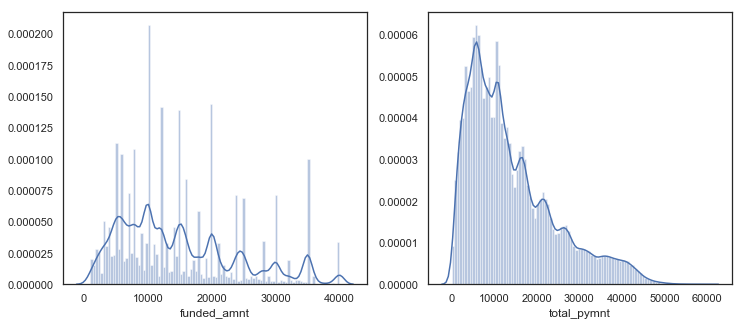

In [26]:
#Histogram of funded amount and total payments

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))
sns.distplot(df.loc[:,'funded_amnt'], bins = 100, ax = ax1);
sns.distplot(df.loc[:,'total_pymnt'], bins = 100, ax = ax2);

In [27]:
df['loan_outcome'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off':1, 'Default':1})

In [ ]:
#Visualizing with an upper bound on ride_distance to look at the data without outliers
#df1 = df[(df['ride_distance'] < 50000) & (df['ride_duration'] < 15000)]

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
sns.scatterplot(x="funded_amnt", y="annual_inc", data=df, s = 20, alpha = 0.6, ax = ax1, hue = 'loan_outcome');
sns.scatterplot(x="funded_amnt", y="total_pymnt", data=df, s = 20, alpha = 0.6, ax = ax2, hue = 'loan_outcome');

C:\Anaconda\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 216x216 with 0 Axes>

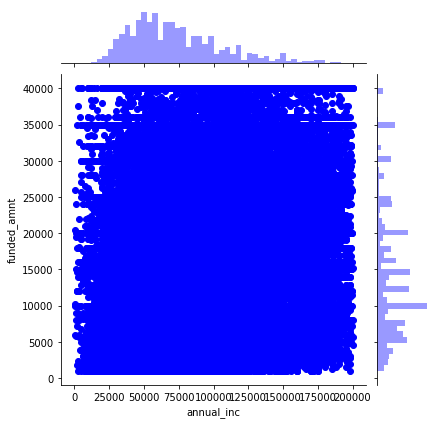

In [18]:
plt.figure(figsize=(3,3))
loan_df = df[df['annual_inc'] < 200000]
g = sns.jointplot(x=loan_df.annual_inc, y=loan_df.funded_amnt, size=6, color='b');

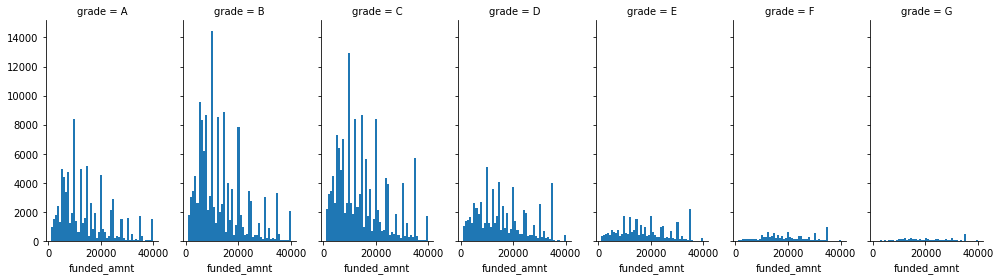

In [19]:
g = sns.FacetGrid(df, col="grade", height=4, aspect=.5, col_order=['A','B','C','D','E','F','G'])
g = g.map(plt.hist, "funded_amnt", bins = 50)

<Figure size 1080x432 with 0 Axes>

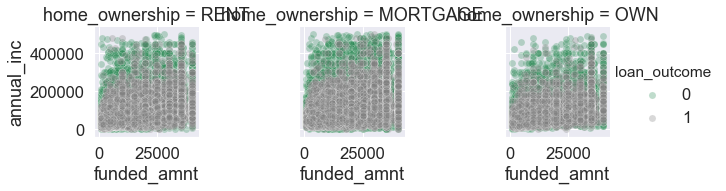

In [104]:
#Annual income of those who paid back seems to be higher across home ownership categories
loan_df = df[(df['annual_inc'] < 500000) & (df['home_ownership'].isin(['RENT', 'MORTGAGE', 'OWN']))]
kws = dict(s=50, linewidth=.5, edgecolor="w")
pal = {0:"seagreen", 1:"gray"}
g = sns.FacetGrid(loan_df, col="home_ownership", hue="loan_outcome", palette=pal, hue_order=[0,1])
g = (g.map(plt.scatter, "funded_amnt", "annual_inc", **kws, alpha = 0.3).add_legend())

C:\Anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


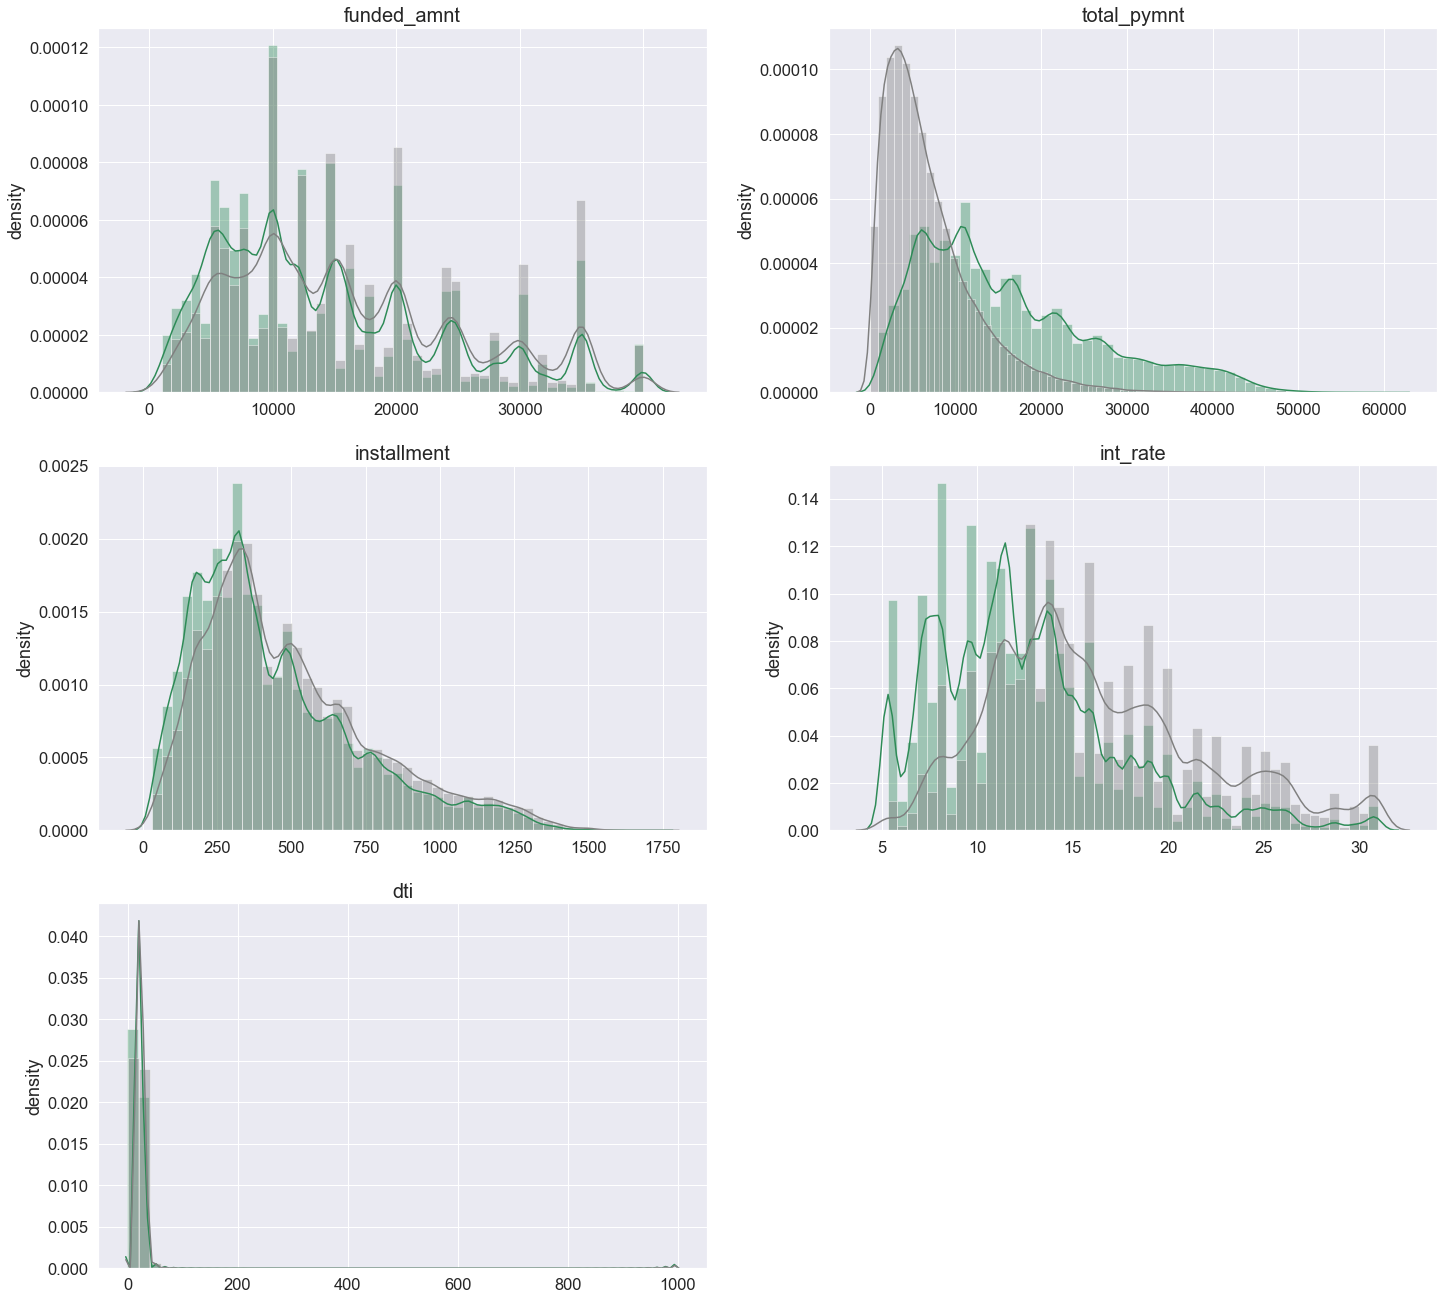

In [102]:
columns = df[['funded_amnt', 'total_pymnt', 'installment', 'int_rate', 'dti']].columns

grid = gridspec.GridSpec(24, 2)
plt.figure(figsize=(24,24*8))

default = df['loan_outcome'] == 1
paid = df['loan_outcome'] == 0

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[col][paid], bins = 50, color='seagreen') 
    sns.distplot(df[col][default], bins = 50, color='gray') 
    ax.set_ylabel('density',)
    ax.set_title(str(col), fontsize = 20)
    ax.set_xlabel('')
plt.show()

In [158]:
float_df = df.copy()
float_df.loc[float_df['dti'] > 50, 'dti'] = 50

C:\Anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


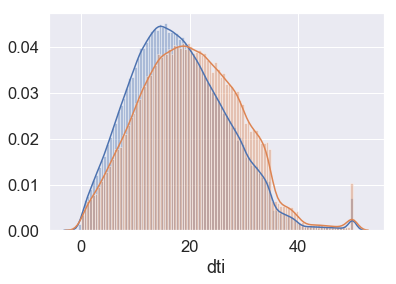

In [159]:
default = df['loan_outcome'] == 1
paid = df['loan_outcome'] == 0
sns.distplot(float_df['dti'][paid], bins = 100)
sns.distplot(float_df['dti'][default], bins = 100)

C:\Anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


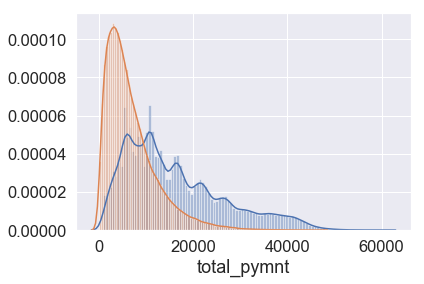

In [160]:
default = df['loan_outcome'] == 1
paid = df['loan_outcome'] == 0
sns.distplot(float_df['total_pymnt'][paid], bins = 100)
sns.distplot(float_df['total_pymnt'][default], bins = 100)

C:\Anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


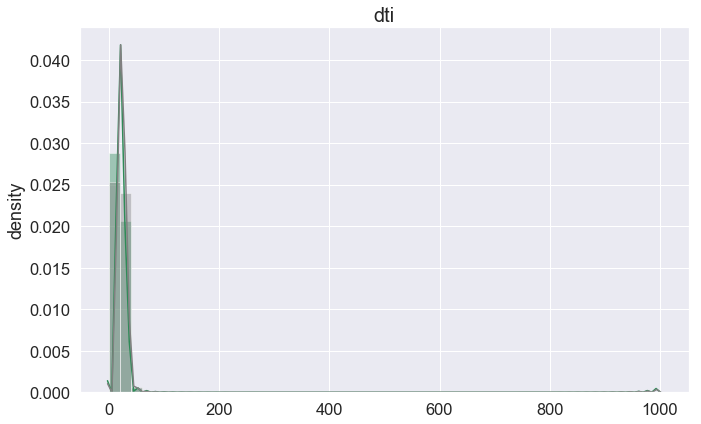

In [156]:
columns = df[['dti']].columns

grid = gridspec.GridSpec(24, 2)
plt.figure(figsize=(24,24*8))

default = df['loan_outcome'] == 1
paid = df['loan_outcome'] == 0

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[col][paid], bins = 50, color='seagreen') 
    sns.distplot(df[col][default], bins = 50, color='gray') 
    ax.set_ylabel('density',)
    ax.set_title(str(col), fontsize = 20)
    ax.set_xlabel('')
plt.show()

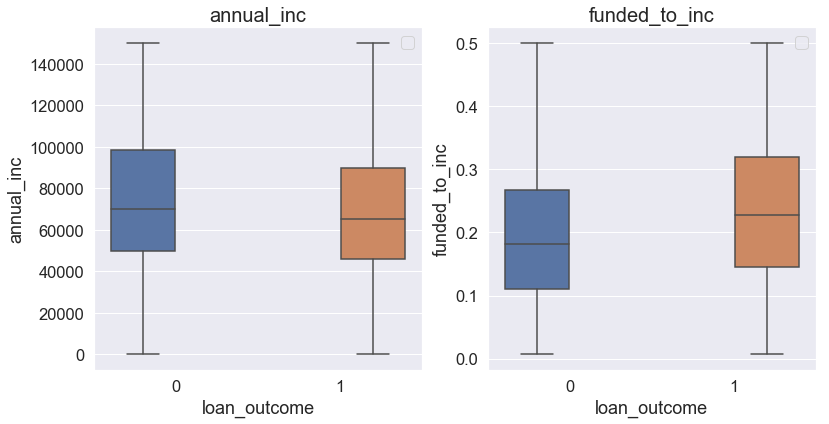

In [113]:
float_df = df.copy()
float_df.loc[float_df['dti'] > 40, 'dti'] = 40
float_df.loc[float_df['annual_inc'] > 150000, 'annual_inc'] = 150000
float_df.loc[float_df['revol_bal'] > 25000, 'revol_bal'] = 25000

float_df['funded_to_inc'] = float_df['funded_amnt']/float_df['annual_inc']
float_df.loc[float_df['funded_to_inc'] > 0.5, 'funded_to_inc'] = 0.5

columns = float_df.loc[:,['annual_inc', 'funded_to_inc']].columns
                        
grid = gridspec.GridSpec(20, 3)
plt.figure(figsize=(20,25*6))

for n, col in enumerate(float_df[columns]):
    ax = plt.subplot(grid[n])
    sns.boxplot(x = 'loan_outcome', y = float_df[col], data = float_df, hue = 'loan_outcome') 
    ax.set_title(str(col), fontsize = 20)
    ax.legend('')
plt.show()

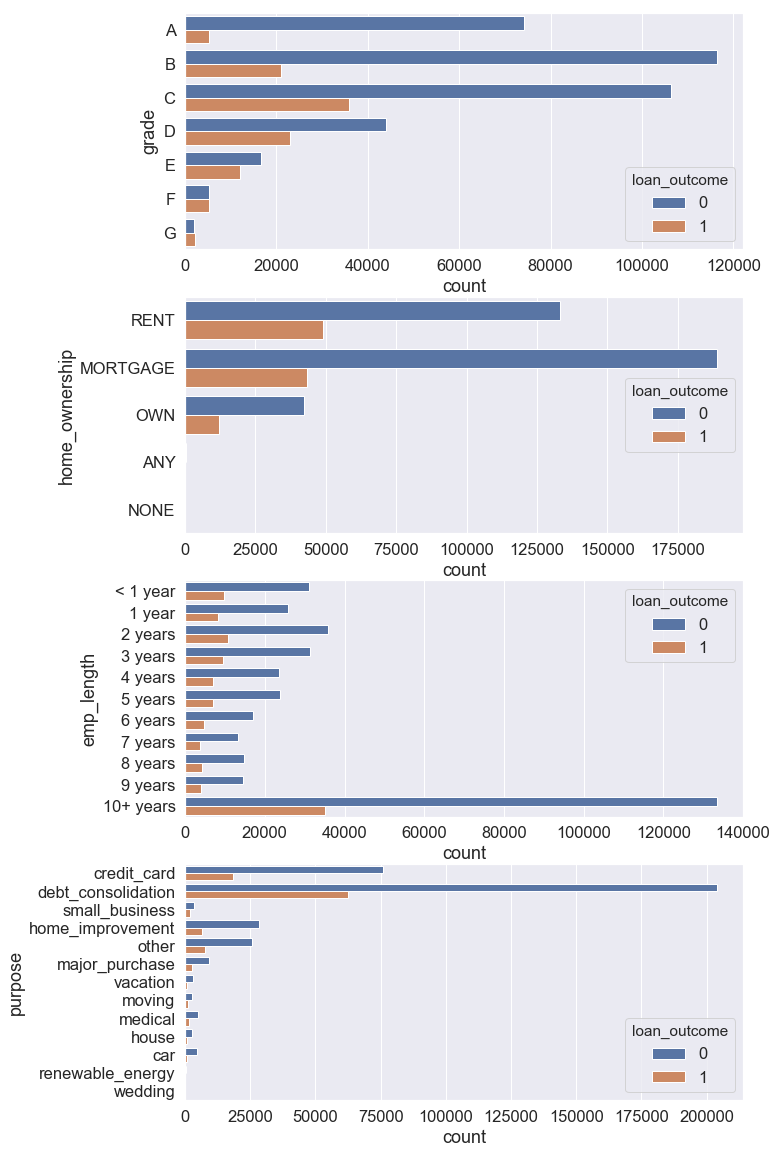

In [107]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (10,20))
sns.countplot(y="grade", hue="loan_outcome", data=df, order=['A','B','C','D','E','F','G'], ax = ax1)
sns.countplot(y="home_ownership", hue="loan_outcome", data=df, ax = ax2)
sns.countplot(y="emp_length", hue="loan_outcome", data=df, order = ['< 1 year', '1 year', \
                            '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', \
                               '8 years', '9 years', '10+ years'], ax = ax3)
sns.countplot(y="purpose", hue="loan_outcome", data=df, ax = ax4)

In [169]:
def_col = df.groupby('grade').agg({'loan_outcome' :'mean',
                                  'int_rate':['mean', 'size']})

In [173]:
def_col.columns = ['_'.join(i) for i in def_col.columns]

In [174]:
def_col

,loan_outcome_mean,int_rate_mean,int_rate_size
grade,,,
A,0.065433,6.889805,79455
B,0.152370,10.365466,137232
C,0.251714,13.986907,142209
D,0.342715,18.509637,66866
E,0.421358,23.322176,28617
F,0.504319,27.247072,10420
G,0.532661,29.901238,3965


In [ ]:

def_col.columns = ['Loan_purpose', 'Default_rate']
def_col['Default_rate'] = def_col['Default_rate']*100

Text(0.5, 1.0, 'Loan purpose')

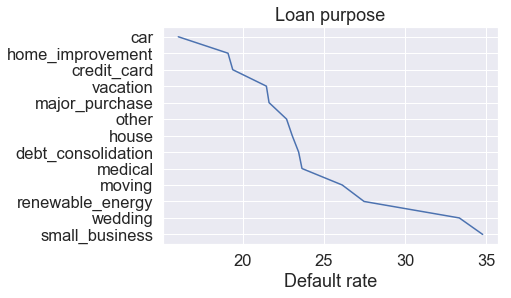

In [152]:
plt.plot('Default_rate','Loan_purpose', data = def_col)
plt.xlabel('Default rate')
plt.title('Loan purpose')

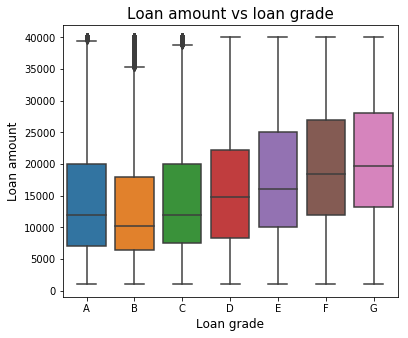

In [69]:
plt.figure(figsize = (6,5))

g = sns.boxplot(x='grade', y="loan_amnt", data=df, order=['A','B','C','D','E','F','G'])
g.set_xticklabels(g.get_xticklabels())
g.set_xlabel("Loan grade", fontsize=12)
g.set_ylabel("Loan amount", fontsize=12)
g.set_title("Loan amount vs loan grade", fontsize=15)

plt.show()

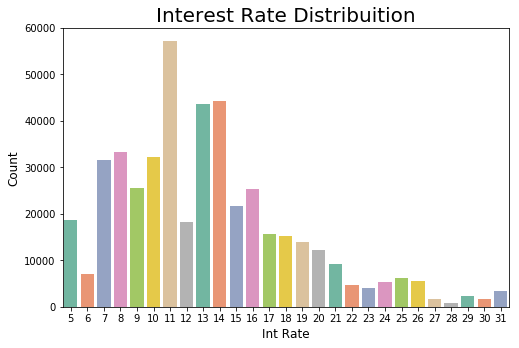

In [35]:
f, ax = plt.subplots(figsize=(8, 5))
df['int_round'] = df['int_rate'].round(0).astype(int)

g1 = sns.countplot(x="int_round",data=df, 
                   palette="Set2")
g1.set_xlabel("Int Rate", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Interest Rate Distribuition", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.6,top = 0.9)
plt.show()

C:\Anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


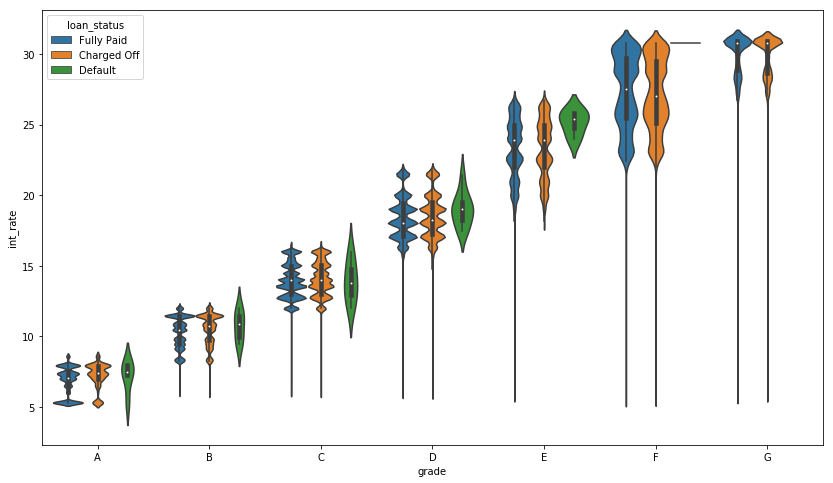

In [38]:
f, ax = plt.subplots(figsize=(14, 8))
sns.violinplot(x='grade', y='int_rate', hue='loan_status', data=df, order=['A','B','C','D','E','F','G'])

C:\Anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


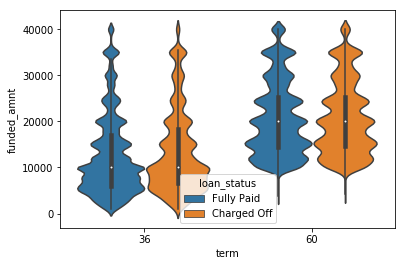

In [39]:
f, ax = plt.subplots(figsize=(6, 4))
loan_df = df[(df['loan_status'] == 'Fully Paid') | (df.loan_status == 'Charged Off')]

sns.violinplot(x='term', y='funded_amnt', hue='loan_status', data=loan_df)

In [41]:
df['loan_status'].value_counts()

Fully Paid     358092
Charged Off    102846
Default        32    
Name: loan_status, dtype: int64

In [42]:
df['loan_outcome'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off':1, 'Default':1})
#df['loan_outcome'] = df['loan_status'].apply(lambda loan_status:0 if loan_status == 0 else 1)
float_df = df[float_cols+['loan_outcome']]
float_df['loan_outcome'].value_counts()

0    358092
1    102878
Name: loan_outcome, dtype: int64

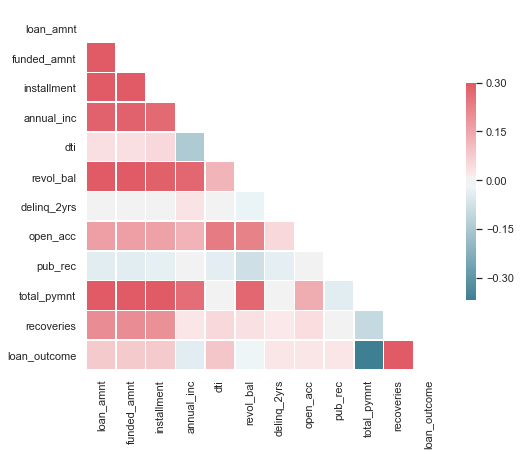

In [45]:
#plt.figure(figsize=(6,6))

sns.set(style="white")

# Compute the correlation matrix
corr = float_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))


# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [46]:
continuous_features = list(float_cols + perc_cols)
discrete_features = list(set(cat_cols) - set(["loan_status"]))
continuous_features = [i for i in continuous_features if i not in ["total_pymnt", "recoveries"]]
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb", "ret_INTc"]

In [47]:
os.getcwd()

'C:\\Anaconda\\semester1\\p2p'

In [48]:
pickle_file = 'C:\Anaconda\semester1\p2p\clean_data.pickle'

In [49]:
pickle.dump([df, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb"))

In [57]:
df.home_ownership.value_counts()

MORTGAGE    231884
RENT        182369
OWN         54259 
ANY         250   
NONE        2     
Name: home_ownership, dtype: int64